モジュールのインポート

In [63]:
!pip uninstall chainer

Uninstalling chainer-5.1.0:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/chainer-5.1.0.dist-info/*
    /usr/local/lib/python3.6/dist-packages/chainer/*
    /usr/local/lib/python3.6/dist-packages/chainermn/*
Proceed (y/n)? y
  Successfully uninstalled chainer-5.1.0


In [64]:
!pip uninstall cupy-cuda92

Skipping cupy-cuda92 as it is not installed.


In [65]:
!curl https://colab.chainer.org/install | CHAINER_VERSION="==5.1.0" CUPY_VERSION="==5.1.0" sh -

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1580  100  1580    0     0  18588      0 --:--:-- --:--:-- --:--:-- 18588
+ apt -y -q install cuda-libraries-dev-10-0
Reading package lists...
Building dependency tree...
Reading state information...
cuda-libraries-dev-10-0 is already the newest version (10.0.130-1).
0 upgraded, 0 newly installed, 0 to remove and 3 not upgraded.
+ pip install -q cupy-cuda100 ==5.1.0 chainer ==5.1.0
+ set +ex
Installation succeeded!


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import chainer
from chainer import cuda
from chainer import Variable
from chainer import functions as F
from chainer import links as L

In [81]:
chainer.print_runtime_info()
print('GPU availability:', chainer.cuda.available)
print('cuDNN availablility:', chainer.cuda.cudnn_enabled)

Platform: Linux-4.14.79+-x86_64-with-Ubuntu-18.04-bionic
Chainer: 5.1.0
NumPy: 1.14.6
CuPy:
  CuPy Version          : 5.1.0
  CUDA Root             : /usr/local/cuda
  CUDA Build Version    : 10000
  CUDA Driver Version   : 10000
  CUDA Runtime Version  : 10000
  cuDNN Build Version   : 7301
  cuDNN Version         : 7301
  NCCL Build Version    : 2307
iDeep: 2.0.0.post3
GPU availability: True
cuDNN availablility: True


In [0]:
class MLP(chainer.Chain):
    #Constructor
    def __init__(self, initializer = None):
        super().__init__(
            Conv1 = L.Convolution2D(1, 30, 5, stride = 1, initialW = initializer),
            Affine2 = L.Linear(4320, 100, initialW = initializer),
            Affine3 = L.Linear(100, 10, initialW = initializer)
        )
        chainer.config.train = True
        
    #Forward operation
    def __call__(self, x, t = None):
        ReLU1_out = F.relu(self.Conv1(x))
        Max_Pooling1_out = F.max_pooling_2d(ReLU1_out, ksize = 2, stride = 2)
        ReLU2_out = F.relu(self.Affine2(Max_Pooling1_out))
        Affine3_out = self.Affine3(ReLU2_out)
        
        if chainer.config.train:
            return F.softmax_cross_entropy(Affine3_out, t)
        else:
            return Affine3_out

In [0]:
model = MLP(initializer = chainer.initializers.GlorotNormal())

GPU対応

In [128]:
cuda.get_device(0).use()
model.to_gpu()

In [129]:
optimizer = chainer.optimizers.Adam()
optimizer.use_cleargrads()
optimizer.setup(model)

データセット作成

In [0]:
train, test = chainer.datasets.get_mnist(ndim = 3)
x_train = train._datasets[0]
t_train = train._datasets[1]
x_test = test._datasets[0]
t_test = test._datasets[1]

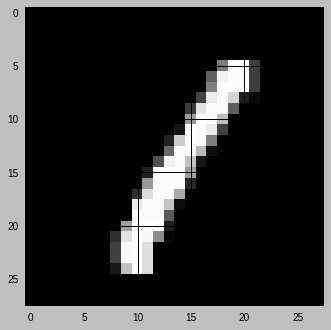

In [131]:
plt.style.use('grayscale')
plt.imshow(x_train[3]. reshape (28, 28))
plt.show()

GPU変換

In [0]:
xp = cuda.cupy

In [0]:
x_train_gpu = xp.asarray(x_train)
t_train_gpu = xp.asarray(t_train)
x_test_gpu = xp.asarray(x_test)
t_test_gpu = xp.asarray(t_test)

In [0]:
train_loss_list = []
test_accuracy_list = []
epoch_list = []
def training():
    for epoch in range(20):
        N = len(x_train)
        batch_size = 500
        train_perm = np.random.permutation(N)
        
        epoch_list.append(epoch)
        batch_loss_list = []
        for i in range(0, N, batch_size):
            #Set mini-batch
            x_batch = x_train_gpu[train_perm[i: i + batch_size]]
            t_batch = t_train_gpu[train_perm[i: i + batch_size]]
            #Forward operation
            loss = model(x_batch, t_batch)
            
            batch_loss_list.append(loss.data)
            #Backward operation
            model.cleargrads()
            loss.backward()
            #Update parameters
            optimizer.update()

        #accuracyの計算
        accuracy = model(x_test_gpu, t_test_gpu)
        
        test_accuracy_list.append(1.0 - accuracy.data)
        batch_loss_mean = sum(batch_loss_list) / len(batch_loss_list)
        train_loss_list.append(batch_loss_mean)
        #print('Accuracy', 1.0 - accuracy.data)
        #print('Loss', batch_loss_mean)
    
    return train_loss_list, test_accuracy_list

In [0]:
loss_list, accuracy_list = training()

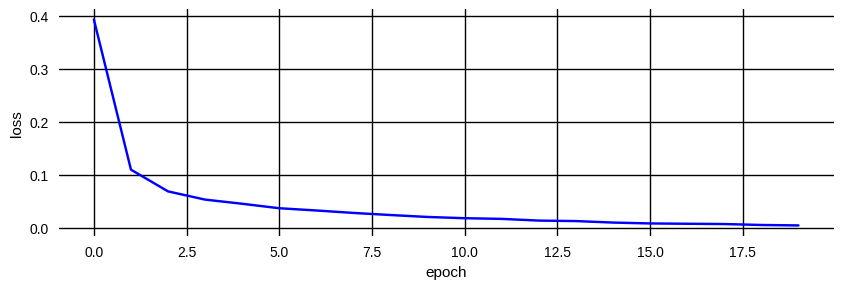

In [143]:
fig = plt.figure(figsize=(10,3), dpi=100, facecolor='w')
ax1 = fig.add_subplot(1,1,1)
plt.xlabel("epoch")
plt.ylabel("loss")
ax1.plot(epoch_list, loss_list, color='blue')
plt.show()

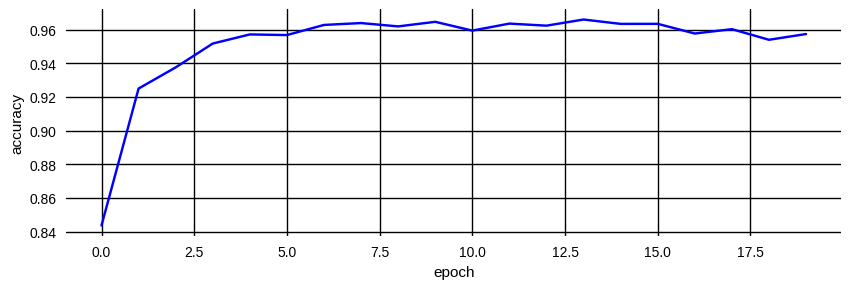

In [137]:
fig = plt.figure(figsize=(10,3), dpi=100, facecolor='w')
ax2 = fig.add_subplot(1,1,1)
plt.xlabel("epoch")
plt.ylabel("accuracy")
ax2.plot(epoch_list, accuracy_list, color='blue')
plt.show()